## Set-up

### Imports

In [152]:
import os
import sys
from typing import Tuple, List, Callable

In [153]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

In [190]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, SubsetRandomSampler
from torchvision import transforms
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.loader import DenseDataLoader
from torch_geometric.transforms import ToDense, ToSparseTensor

In [155]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator

In [182]:
import seaborn as sns

In /Users/arnauddhaene/miniconda3/envs/ds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/arnauddhaene/miniconda3/envs/ds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/arnauddhaene/miniconda3/envs/ds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/arnauddhaene/miniconda3/envs/ds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

In [156]:
sys.path.append(os.path.abspath('../src/'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, fetch_data, Preprocessor

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

### Fetch data

In [174]:
dataset_train, dataset_test = load_dataset(dense=True)

## KFold

In [175]:
kfold = KFold(n_splits=5, shuffle=True)

In [176]:
for fold, (I_train, I_valid) in enumerate(kfold.split(dataset_train)):
    
    print(f'Fold no. {fold}')
    print(f'Train size: {len(I_train)}, Valid size: {len(I_valid)}')
    print(f'Intersection: {len(list(set(I_train) & set(I_valid)))}')
    
    sampler_train = SubsetRandomSampler(I_train)
    sampler_valid = SubsetRandomSampler(I_valid)
    
    loader_train = DenseDataLoader(dataset_train, batch_size=8, sampler=sampler_train)
    loader_valid = DenseDataLoader(dataset_train, batch_size=8, sampler=sampler_valid)

Fold no. 0
Train size: 56, Valid size: 15
Intersection: 0
Fold no. 1
Train size: 57, Valid size: 14
Intersection: 0
Fold no. 2
Train size: 57, Valid size: 14
Intersection: 0
Fold no. 3
Train size: 57, Valid size: 14
Intersection: 0
Fold no. 4
Train size: 57, Valid size: 14
Intersection: 0


In [166]:
loader = DataLoader(dataset_train, batch_size=8)

In [177]:
dense_batch = next(iter(loader_train))

In [192]:
dense_batch

Batch(x=[8, 126, 43], mask=[8, 126], num_nodes=[8], adj=[8, 126, 126], y=[8, 1])

<AxesSubplot:>

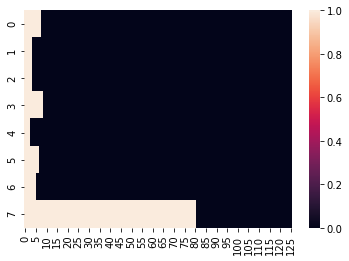

In [183]:
sns.heatmap(dense_batch.mask.detach().numpy())

In [167]:
batch = next(iter(loader))

In [168]:
batch

Batch(x=[140, 43], edge_index=[2, 1391], y=[8], num_nodes=140, batch=[140], ptr=[9])

In [184]:
dadj = to_dense_adj(batch.edge_index, batch.batch, max_num_nodes=126)

In [188]:
unique, counts = np.unique(batch.batch, return_counts=True)

In [189]:
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([60,  4,  3, 23, 17,  7, 15, 11]))

In [194]:
xx, mask = to_dense_batch(batch.x, batch.batch, max_num_nodes=126)

In [195]:
xx.shape

torch.Size([8, 126, 43])

<AxesSubplot:>

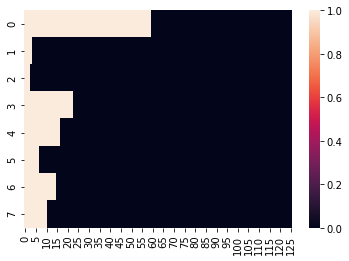

In [196]:
sns.heatmap(mask.detach().numpy())

## Rewrites

### Rewritten `preprocess`

In [38]:
def preprocess(
    labels: pd.Series, lesions: pd.DataFrame, patients: pd.DataFrame,
    test_size: float = 0.2, seed: int = 27, verbose: int = 1
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Preprocess filtered raw data into train, validation, and test splits.
    Imputation, standardization, and one-hot encoding of features using sklearn pipelines.

    Args:
        labels (pd.Series): `gpcr_id` indexed Series with progression labels. 1 is NPD.
        lesions (pd.DataFrame): gpcr_id` indexed lesion-level data.
        patients (pd.DataFrame): `gpcr_id` indexed patient-level data including blood screens.
        test_size (float, optional): Ratio of test set. Defaults to 0.2.
        seed (int, optional): Random seed. Defaults to 27.
        verbose (int, optional): tuneable parameter for output verbosity. Defaults to 1.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
            * X_train (pd.DataFrame): `gpcr_id` indexed training dataset.
            * X_test (pd.DataFrame): `gpcr_id` indexed testing dataset.
            * y_train (pd.Series): `gpcr_id` indexed training Series with progression labels. 1 is NPD.
            * y_test (pd.Series): `gpcr_id` indexed test Series with progression labels. 1 is NPD.
    """
    
    I_train, I_test, y_train, y_test = \
        train_test_split(labels.index, labels, test_size=test_size, random_state=seed)
        
    lesions_pp = Preprocessor(
        pipe=ColumnTransformer(
            [('scaler', StandardScaler(), make_column_selector(dtype_include=np.number)),
             ('one-hot', OneHotEncoder(),
              make_column_selector(dtype_include=object))]),
        feats_out_fn=lambda c: c.transformers_[0][-1] + list(c.transformers_[1][1].categories_[0])
    )
    
    patients_numerical = list(patients.select_dtypes(np.number).columns)
    patients_categorical = list(patients.select_dtypes([bool, object]).columns)
    patients_categorical.remove('immuno_therapy_type')

    features_range = list(range(len(patients_numerical) + len(patients_categorical) + 1))
    bp = np.cumsum([len(patients_numerical), len(patients_categorical), 1])

    clf_patients = Pipeline([
        ('imputers', ColumnTransformer([
            ('median', SimpleImputer(strategy='median'), patients_numerical),
            ('frequent', SimpleImputer(strategy='most_frequent'), patients_categorical)
        ], remainder='passthrough')),
        ('preprocess', ColumnTransformer([
            ('scaler', StandardScaler(), features_range[0:bp[0]]),
            ('one-hot', OneHotEncoder(handle_unknown='ignore'),
             features_range[bp[0]:bp[1]]),
            ('count-vec', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][0])
        ], remainder='passthrough')),
    ])

    patients_pp = Preprocessor(
        pipe=clf_patients,
        feats_out_fn=lambda c: (c.named_steps['imputers'].transformers_[0][2] \
                                + list(c.named_steps['preprocess'].transformers_[1][1].get_feature_names()) \
                                + c.named_steps['preprocess'].transformers_[2][1].get_feature_names())
    )

    lesions_pp.fit(lesions.loc[I_train])

    lesions_train = lesions_pp.transform(lesions.loc[I_train])
    lesions_test = lesions_pp.transform(lesions.loc[I_test])
    
    patients_pp.fit(patients.loc[I_train])

    patients_train = patients_pp.transform(patients.loc[I_train])
    patients_test = patients_pp.transform(patients.loc[I_test])
    
    X_train = pd.merge(lesions_train, patients_train, left_index=True, right_index=True)
    X_test = pd.merge(lesions_test, patients_test, left_index=True, right_index=True)
    
    if verbose > 0:
        print('Processed and split dataset into \n' \
              + f'  Train: {y_train.shape[0]} \n' \
              + f'  Test: {y_test.shape[0]}')
    
    return X_train, X_test, y_train, y_test

### Rewritten `load_dataset`

In [42]:
def load_dataset(
    connectivity: str = 'wasserstein', test_size: float = 0.2, seed: int = 27,
    dense: bool = False, verbose: int = 0
) -> Tuple[List[Data], List[Data]]:
    """
    Get training, validation, and testing DataLoaders.
    Mainly used as a high-level data fetcher in the running script.

    Args:
        connectivity (str, optional): node connectivity method.. Defaults to 'wasserstein'.
        batch_size (int, optional): [description]. Defaults to 8.
        test_size (float, optional): Ratio of test set. Defaults to 0.2.
        seed (int, optional): Random seed. Defaults to 27.
        dense (bool, optional): Output a DenseDataLoader
        verbose (int, optional): tuneable parameter for output verbosity. Defaults to 1.

    Returns:
        Tuple[List[Data], List[Data]]:
            * loader_train (List[Data]): packaged training dataset.
            * loader_test (List[Data]): packaged testing dataset.
    """

    labels, lesions, patients = fetch_data(verbose)
    
    X_train, X_test, y_train, y_test = \
        preprocess(labels, lesions, patients,
                   test_size=test_size, seed=seed,
                   verbose=verbose)
        
    dataset_train = create_dataset(X=X_train, Y=y_train, dense=dense,
                                  connectivity=connectivity, verbose=verbose)
    
    # In the test loader we set the batch size to be
    # equal to the size of the whole test set
    dataset_test = create_dataset(X=X_test, Y=y_test, dense=dense,
                                 connectivity=connectivity, verbose=verbose)
    
    if verbose > 0:
        print('Final amount of datapoints \n' \
              + f'  Train: {len(dataset_train)} \n' \
              + f'  Test: {len(dataset_test)}')

    return dataset_train, dataset_test

### Rewritten `create_dataset`

In [40]:
def create_dataset(
    X: pd.DataFrame, Y: pd.Series, dense: bool = False, connectivity: str = 'wasserstein',
    distance: float = 0.5, verbose: int = 0
) -> List[Data]:
    """Packages preprocessed data and its labels into a dataset

    Args:
        X (pd.DataFrame): `gpcr_id` indexed datapoints (lesions)
        Y (pd.Series): `gpcr_id` indexed labels. 1 is NPD.
        dense (bool, optional): create dense Graph representations
        connectivity (str, optional): node connectivity method. Defaults to 'wasserstein'.
        distance (float, optional): if `wasserstein` connectivity is chosen,
            the threshold distance in order to create an edge between nodes. Defaults to 0.5.
        verbose (int, optional): tuneable parameter for output verbosity.. Defaults to 0.

    Raises:
        ValueError: acceptable values for connectivity are: 'fully', 'organ', and 'wasserstein'

    Returns:
        dataset
    """
    
    lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
    # Filter out benign lesions and non-post-1 studies
    lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')]
    
    dataset = []
    skipped = 0
    
    if dense:
        max_num_nodes = lesions.groupby('gpcr_id').size().max()
        to_dense = ToDense(max_num_nodes)

    for patient in list(X.index.unique()):

        # Create patient sub-DataFrame of all his post-1 study lesions
        pdf = lesions[lesions.gpcr_id == patient].reset_index()
        
        # Sanity check
        assert pdf.shape[0] == X[X.index == patient].shape[0], f'Unequal lesion count for patient {patient}'
        
        num_nodes = pdf.shape[0]
        edge_index = []
        
        # Skip single-noded graphs
        if num_nodes < 2:
            skipped += 1
            continue

        # Connect lesions using different methodologies
        if connectivity == 'organ':
            # Connect all lesions that are assigned to the same organ
            for i in range(num_nodes):
                source = pdf.loc[i].assigned_organ
                targets = list(pdf[pdf.assigned_organ == source].index)

                edge_index.extend([[i, j] for j in targets if i != j])
                
        elif connectivity == 'fully':
            # Create a fully-connected network representation
            edge_index = list(permutations(range(num_nodes), 2, ))
            
        elif connectivity == 'wasserstein':
            # Use the mean and std of the SUV of each lesion to simulate SUV distributions (normal)
            # and subsequently connect nodes with similar SUV distributions using the Wasserstein distance
            # as a distance metric
            for i in range(num_nodes):
                source_mean, source_sd = pdf.loc[i].mean_suv_val, pdf.loc[i].sd_suv_val
                source_distribution = np.random.normal(source_mean, source_sd, 1000)
                
                targets = [id for id, mu, sd in zip(pdf.index, pdf.mean_suv_val, pdf.sd_suv_val)
                           if wasserstein_distance(source_distribution,
                                                   np.random.normal(mu, sd, 1000)) < distance]

                edge_index.extend([[i, j] for j in targets])
            
        else:
            raise ValueError(f'Connectivity value not accepted: {connectivity}.'
                             "Must be either 'fully', 'wasserstein', or 'organ'.")

        edge_index = torch.tensor(edge_index).t().long()
    
        x = torch.tensor(X.loc[patient].reset_index(drop=True).to_numpy().astype(np.float32))
        y = torch.tensor(Y.loc[patient])

        data = Data(x=x, edge_index=edge_index, num_nodes=num_nodes, y=y.reshape(-1))

        dataset.append(to_dense(data) if dense else data)
        
    if verbose > 0 and skipped > 0:
        print(f'Skipped {skipped} graphs as they have less than 2 nodes.')
        
    return dataset

### TrainingMetrics

In [131]:
class TrainingMetrics():

    def __init__(self, run: int = 0):
        
        self.run = run
        self.storage = []
    
    def log_metric(self, metric: str, value: float, step: int = 0):
        
        self.storage.append(dict(metric=metric, value=value, step=step, run=self.run))

In [132]:
metrics = TrainingMetrics(run=0)

In [133]:
metrics.log_metric('Accuracy - training', 0.94, 0)
metrics.log_metric('Accuracy - training', 0.92, 1)
metrics.log_metric('Accuracy - training', 0.93, 2)
metrics.log_metric('Accuracy - validation', 0.81, 0)
metrics.log_metric('Accuracy - validation', 0.51, 1)
metrics.log_metric('Accuracy - validation', 0.91, 2)

In [134]:
n = TrainingMetrics(1)

In [135]:
n.log_metric('Accuracy - training', 0.74, 0)
n.log_metric('Accuracy - training', 0.72, 1)
n.log_metric('Accuracy - training', 0.73, 2)
n.log_metric('Accuracy - validation', 0.91, 0)
n.log_metric('Accuracy - validation', 0.91, 1)
n.log_metric('Accuracy - validation', 0.21, 2)

In [136]:
df = pd.concat([
    pd.DataFrame(metrics.storage), pd.DataFrame(n.storage)
])

In [138]:
list(df.groupby(['metric', 'step']).value.std().reset_index().iterrows())

[(0,
  metric    Accuracy - training
  step                        0
  value                0.141421
  Name: 0, dtype: object),
 (1,
  metric    Accuracy - training
  step                        1
  value                0.141421
  Name: 1, dtype: object),
 (2,
  metric    Accuracy - training
  step                        2
  value                0.141421
  Name: 2, dtype: object),
 (3,
  metric    Accuracy - validation
  step                          0
  value                  0.070711
  Name: 3, dtype: object),
 (4,
  metric    Accuracy - validation
  step                          1
  value                  0.282843
  Name: 4, dtype: object),
 (5,
  metric    Accuracy - validation
  step                          2
  value                  0.494975
  Name: 5, dtype: object)]

In [140]:
for index, feature in df.groupby(['metric', 'step']).value.std().reset_index().iterrows():
    print(f'{feature.metric}: {feature.value} | {feature.step}')

Accuracy - training: 0.14142135623730948 | 0
Accuracy - training: 0.1414213562373096 | 1
Accuracy - training: 0.1414213562373096 | 2
Accuracy - validation: 0.0707106781186547 | 0
Accuracy - validation: 0.28284271247461906 | 1
Accuracy - validation: 0.49497474683058335 | 2


In [141]:
from torch_geometric.nn import GraphConv

In [143]:
GraphConv(5, 5).reset_parameters()

In [148]:
from src.models import GNN